# Análise Exploratória dos dados da IMBd

Mini-Projeto utilizando Linguagem Python, SQL e Banco de Dados SQLite para fazer uma análise exploratória dos dados do IMBD.

## Instalando e Carregando Pacotes

In [2]:
# Instala o pacote
!pip install -q imdb-sqlite

Download dos datasets.

In [3]:
# Instala o pacote
# https://pypi.org/project/pycountry/
!pip install -q pycountry

In [4]:
# Imports
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

## Carregando os Dados

Download dos dados

In [5]:
%%time
!imdb-sqlite

CPU times: total: 328 ms
Wall time: 55min 47s


2022-07-23 18:43:10,936 GET https://datasets.imdbws.com/name.basics.tsv.gz -> downloads\name.basics.tsv.gz
2022-07-23 18:43:55,008 GET https://datasets.imdbws.com/title.basics.tsv.gz -> downloads\title.basics.tsv.gz
2022-07-23 18:44:23,269 GET https://datasets.imdbws.com/title.akas.tsv.gz -> downloads\title.akas.tsv.gz
2022-07-23 18:45:13,331 GET https://datasets.imdbws.com/title.principals.tsv.gz -> downloads\title.principals.tsv.gz
2022-07-23 18:46:28,707 GET https://datasets.imdbws.com/title.episode.tsv.gz -> downloads\title.episode.tsv.gz
2022-07-23 18:46:36,035 GET https://datasets.imdbws.com/title.ratings.tsv.gz -> downloads\title.ratings.tsv.gz
2022-07-23 18:46:37,352 Populating database: imdb.db
2022-07-23 18:46:37,354 Applying schema
2022-07-23 18:46:37,365 Importing file: downloads\name.basics.tsv.gz
2022-07-23 18:46:37,365 Reading number of rows ...
2022-07-23 18:46:43,993 Inserting rows into table: people

  5%|4         | 579018/11792842 [00:11<03:43, 50202.19 rows/s]


 21%|##        | 2433518/11792842 [00:49<03:13, 48445.48 rows/s]


In [6]:
# Conectando no banco de dados
conn = sqlite3.connect("imdb.db")

In [7]:
# Extraindo a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [8]:
# Tipo do objeto
type(tabelas)

pandas.core.frame.DataFrame

In [9]:
# Visualizando o resultado
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [10]:
# Convertendo o dataframe em uma lista
tabelas = tabelas["Table_Name"].values.tolist()

In [11]:
# Extraindo o esquema da tabela
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




# Análise Exploratória dos Dados.

## 1- Quais São as Categorias de Filmes Mais Comuns no IMDB?

Quais são os principais tipos (categorias) dos títulos (filmes)?

In [12]:
# Criando a consulta SQL
consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type''' 

In [13]:
# Extraindo o resultado
resultado1 = pd.read_sql_query(consulta1, conn)

In [14]:
# Visualização do resultado
display(resultado1)

,type,COUNT
0,movie,616241
1,short,880201
2,tvEpisode,6840244
3,tvMiniSeries,44377
4,tvMovie,136834
5,tvPilot,2
6,tvSeries,228482
7,tvShort,10618
8,tvSpecial,37666
9,video,263121


In [15]:
# Calculando o percentual para cada tipo
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [16]:
# Visualização do resultado
display(resultado1)

,type,COUNT,percentual
0,movie,616241,6.779743
1,short,880201,9.683771
2,tvEpisode,6840244,75.254804
3,tvMiniSeries,44377,0.488226
4,tvMovie,136834,1.505416
5,tvPilot,2,0.000022
6,tvSeries,228482,2.513707
7,tvShort,10618,0.116817
8,tvSpecial,37666,0.414393
9,video,263121,2.894797


In [17]:
# Vamos criar um gráfico com apenas 4 categorias:
# As 3 categorias com mais títulos e 1 categoria com todo o restante

# Criando um dicionário vazio
others = {}

# Filtrando o percentual em 5% e soma o total
others['COUNT'] = resultado1[resultado1['percentual'] < 5]['COUNT'].sum()

# Gravando o percentual
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

# Ajustando o nome
others['type'] = 'others'

In [18]:
# Visualização
others

{'COUNT': 752759, 'percentual': 8.281682765009304, 'type': 'others'}

In [19]:
# Filtrando o dataframe de resultado
resultado1 = resultado1[resultado1['percentual'] > 5]

In [20]:
# Append com o dataframe de outras categorias
resultado1 = resultado1.append(others, ignore_index = True)

In [21]:
# Ordenando o resultado
resultado1 = resultado1.sort_values(by = 'COUNT', ascending = False)

In [22]:
# Visualização
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,6840244,75.254804
1,short,880201,9.683771
3,others,752759,8.281683
0,movie,616241,6.779743


In [23]:
# Ajustando os labels
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2)) +'%'+']' for i in resultado1.index]

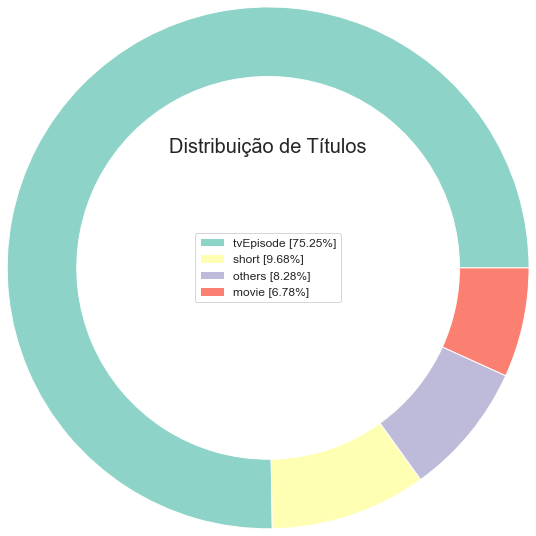

In [24]:
# Plot

# Mapa de cores
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.Set3(np.arange(100))

# Criando a figura
f = plt.figure()

# Pie Plot
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

## 2- Qual o Número de Títulos Por Gênero?

Vamos calcular o número de filmes por gênero e entregar o resultado em valor percentual.

In [25]:
# Criado a consulta SQL
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres''' 

In [26]:
# Resultado
resultado2 = pd.read_sql_query(consulta2, conn)

In [27]:
# Visualização do resultado
display(resultado2)

,genres,COUNT(*)
0,Action,14127
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",6
4,"Action,Adult,Crime",10
...,...,...
1463,"Thriller,Western",43
1464,War,1307
1465,"War,Western",14
1466,Western,5106


In [28]:
# Convertendo as strings para minúsculo
resultado2['genres'] = resultado2['genres'].str.lower().values

In [29]:
# Removendo valores NA (ausentes)
temp = resultado2['genres'].dropna()

Usamos o Countvectorizer para converter a coluna de gêneros em um vetor one-hot encoded para contar o número de filmes em cada gênero.

![title](imagens/one-hot.png)

In [30]:
# Criando um vetor usando expressão regular para filtrar as strings

# https://docs.python.org/3.8/library/re.html
padrao = '(?u)\\b[\\w-]+\\b'

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [31]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [32]:
# Aplicando a vetorização ao dataset sem valores NA
bag_generos = vetor.transform(temp)

In [33]:
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [34]:
# Retornando gêneros únicos
generos_unicos =  vetor.get_feature_names()

In [35]:
# Criando o dataframe de gêneros
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [36]:
# Visualização
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1468 entries, 0 to 1467
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1468 non-null   int64
 1   adult        1468 non-null   int64
 2   adventure    1468 non-null   int64
 3   animation    1468 non-null   int64
 4   biography    1468 non-null   int64
 5   comedy       1468 non-null   int64
 6   crime        1468 non-null   int64
 7   documentary  1468 non-null   int64
 8   drama        1468 non-null   int64
 9   family       1468 non-null   int64
 10  fantasy      1468 non-null   int64
 11  film-noir    1468 non-null   int64
 12  game-show    1468 non-null   int64
 13  history      1468 non-null   int64
 14  horror       1468 non-null   int64
 15  music        1468 non-null   int64
 16  musical      1468 non-null   int64
 17  mystery      1468 non-null   int64
 18  n            1468 non-null   int64
 19  news         1468 non-null   int64
 20  reality-

In [37]:
# Drop da coluna n
generos = generos.drop(columns = 'n', axis = 0)

In [38]:
# Calculando o percentual
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [39]:
# Visualização
generos_percentual.head(10)

drama          17.915531
comedy         16.961853
documentary    15.803815
adventure      14.918256
action         14.509537
romance        13.283379
crime          13.010899
mystery        12.397820
thriller       12.261580
horror         12.193460
dtype: float64

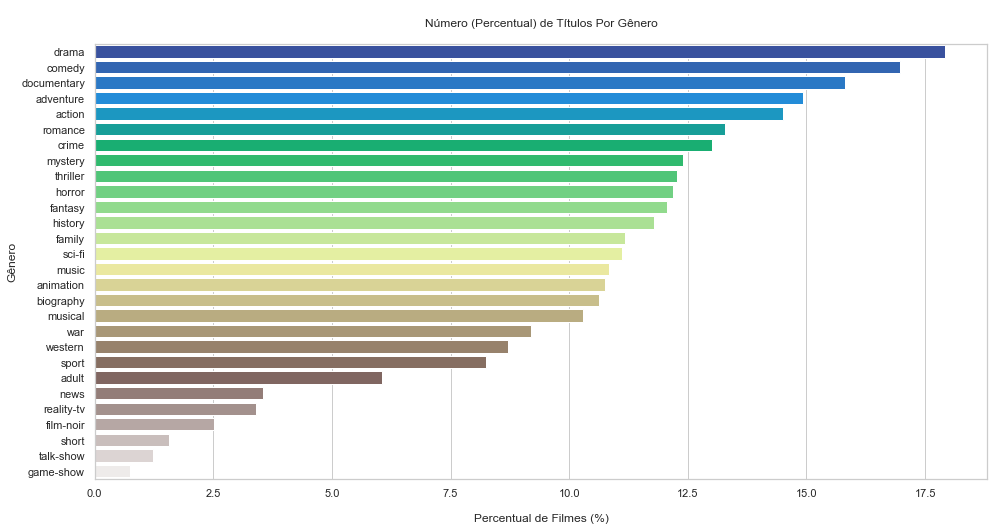

In [40]:
# Plot
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')             
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()

## 3- Qual a Mediana de Avaliação dos Filmes Por Gênero?

Mediana de avaliação dos filmes.

In [41]:
# Consulta SQL
consulta3 = '''
            SELECT rating, genres FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ''' 

In [42]:
# Resultado
resultado3 = pd.read_sql_query(consulta3, conn)

In [43]:
# Visualização
display(resultado3)

,rating,genres
0,5.3,Romance
1,4.5,\N
2,6.0,"Action,Adventure,Biography"
3,4.7,Drama
4,4.5,Drama
...,...,...
278803,5.8,Thriller
278804,6.4,"Drama,History"
278805,3.8,"Adventure,History,War"
278806,8.3,Drama


In [44]:
# Criando uma função para retornar os genêros
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [45]:
# Aplicando a função
generos_unicos = retorna_generos(resultado3)

In [46]:
# Visualização
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [47]:
# Criando listas vazias
genero_counts = []
genero_ratings = []

In [48]:
# Loop
for item in generos_unicos:
    
    # Retorna a contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
  
     # Retorna a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [49]:
# Preparação do dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [50]:
# Visualização
df_genero_ratings.head(20)

,genres,count,rating
0,action,28849,5.80
1,adult,4392,5.80
2,adventure,17443,6.00
3,animation,4759,6.50
4,biography,8498,7.00
5,comedy,68762,6.00
6,crime,23808,6.10
7,documentary,41945,7.30
8,drama,123335,6.30
9,family,10742,6.30


In [51]:
# Drop do índice 18 (news)
# Não queremos essa informação como gênero
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [52]:
# Ordenando o resultado
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

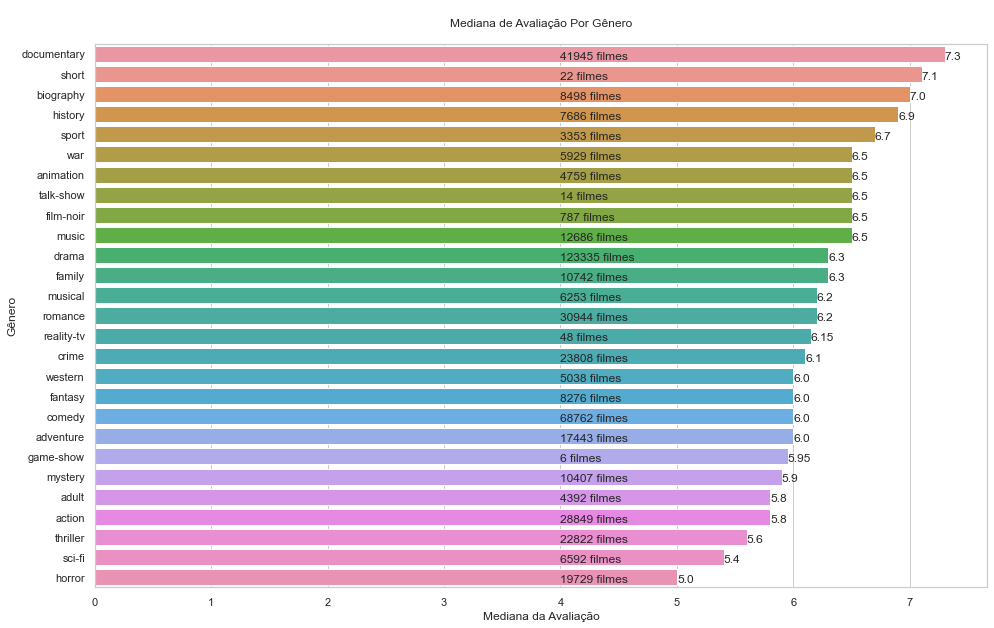

In [53]:
# Plot

# Figura
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

# Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))

plt.ylabel('Gênero')             
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

## 4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?

Mediana de avaliação dos filmes.

In [54]:
# Consulta SQL
consulta4 = '''
            SELECT rating AS Rating, premiered FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ORDER BY premiered
            ''' 

In [55]:
# Resultado
resultado4 = pd.read_sql_query(consulta4, conn)

In [56]:
display(resultado4)

,Rating,premiered
0,5.3,1894
1,6.7,1896
2,4.5,1897
3,4.0,1899
4,3.7,1899
...,...,...
278803,9.4,2022
278804,7.8,2022
278805,6.8,2022
278806,5.0,2022


In [57]:
# Calculamos a mediana ao longo do tempo (anos)
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [58]:
type(ratings)

list

In [59]:
ratings[1:10]

[6.7, 4.5, 3.85, 5.85, 6.2, 3.4, 4.6, 5.4, 4.55]

In [60]:
# Lista de anos
anos = list(set(resultado4['premiered']))

In [61]:
anos[1:10]

[1896, 1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905]

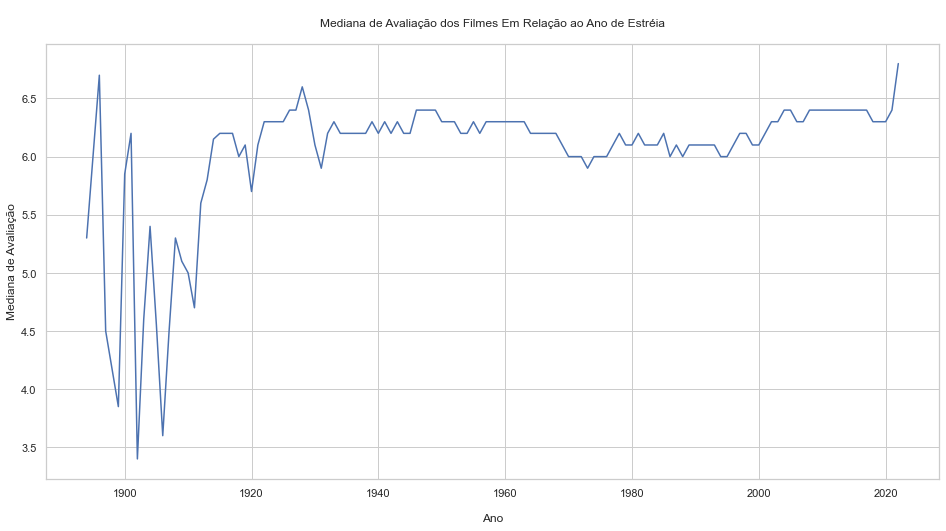

In [62]:
# Plot
plt.figure(figsize = (16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estréia\n')
plt.show()

## 5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?

Número de filmes por gênero. Vamos listar os Top 5.

In [63]:
# Consulta SQL
consulta5 = '''SELECT genres FROM titles ''' 

In [64]:
# Resultado
resultado5 = pd.read_sql_query(consulta5, conn)

In [65]:
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
9089440,"Action,Drama,Family"
9089441,"Action,Drama,Family"
9089442,"Action,Drama,Family"
9089443,Short


In [66]:
# Retorna gêneros únicos
generos_unicos = retorna_generos(resultado5)

In [67]:
# Visualização do resultado
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [68]:
# Fazendo a contagem
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [69]:
# Preparando o dataframe
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [70]:
# Calculando os top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

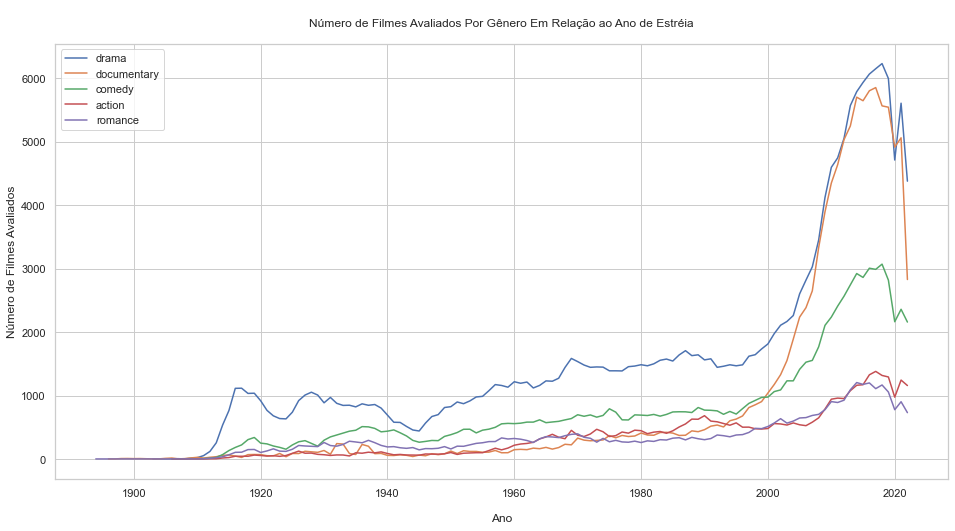

In [71]:
# Plot

# Figura
plt.figure(figsize = (16,8))

# Loop e Plot
for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

## 6- Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.

Percentis e filme mais longo da história.

In [72]:
# Consulta SQL
consulta6 = '''
            SELECT runtime_minutes Runtime 
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ''' 

In [73]:
# Resultado
resultado6 = pd.read_sql_query(consulta6, conn)

In [74]:
display(resultado6)

,Runtime
0,45
1,100
2,70
3,90
4,120
...,...
388719,123
388720,57
388721,100
388722,116


In [75]:
# Loop para cálculo dos percentis
for i in range(101): 
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 47.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 51.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 53.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 57.0
11 percentil da duração (runtime) é: 58.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 61.0
16 percentil da duração (runtime) é: 62.0
17 percentil da duração (runtime) é: 64.0
18 percentil da duração (runtime) é: 65.0
19 percentil da duração (runtime) é: 67.0
20 percentil da duração (runtime) é: 69.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 70.0
23 percentil da duração (runtime) é: 71.0
24 

In [76]:
# Refazendo a consulta e retornando o filme com maior duração
consulta6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
            ''' 

In [77]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [78]:
resultado6

,Runtime,primary_title
0,51420,Logistics


'Logistics' é o filme mais longo da história (até este momento), com 857 horas (51420 minutos). Dirigido por Daniel Andersson e Erika Magnusson, o filme acompanha todo o ciclo de vida de um pedômetro (dispositivo de rastreamento de passos) em ordem cronológica reversa.

## 7- Qual a Relação Entre Duração e Gênero?

Relação entre duração do filme e gênero.

In [79]:
# Consulta SQL
consulta7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres 
            FROM titles 
            WHERE type = 'movie'
            AND runtime_minutes != 'NaN'
            GROUP BY genres
            ''' 

In [80]:
# Resultado
resultado7 = pd.read_sql_query(consulta7, conn)

In [81]:
# Retornando gêneros únicos
generos_unicos = retorna_generos(resultado7)

In [82]:
# Visualização
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [83]:
# Calculando duração por gênero
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [84]:
# Preparando o dataframe
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [85]:
# Removendo índice 18 (news)
df_genero_runtime = df_genero_runtime.drop(index = 18)

In [86]:
# Ordenando os dados
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

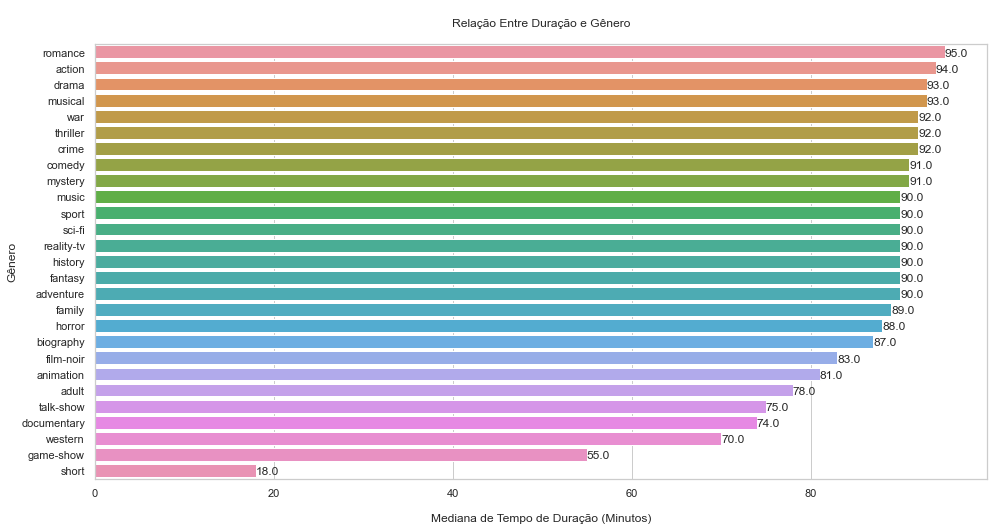

In [87]:
# Plot

# Tamanho da figura
plt.figure(figsize = (16,8))

# Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

## 8- Qual o Número de Filmes Produzidos Por País?

Número de filmes produzidos por país.

In [88]:
# Consulta SQL
consulta8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
            ''' 

In [89]:
# Resultado
resultado8 = pd.read_sql_query(consulta8, conn)

In [90]:
display(resultado8)

,region,Number_of_movies
0,AD,22
1,AE,6866
2,AF,114
3,AG,12
4,AL,1293
...,...,...
229,YUCS,153
230,ZA,7361
231,ZM,15
232,ZRCD,2


In [91]:
# Shape
resultado8.shape

(234, 2)

In [92]:
# Número de linhas
resultado8.shape[0]

234

In [93]:
# Listas auxiliares
nomes_paises = []
contagem = []

In [94]:
# Loop para obter o país de acordo com a região
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except: 
        continue

In [95]:
# Preparando o dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [96]:
# Ordenando o resultado
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)

In [97]:
# Visualização
df_filmes_paises.head(10)

,country,Movie_Count
199,United States,314734
65,United Kingdom,160526
96,Japan,92263
63,France,85682
89,India,84075
32,Canada,80139
47,Germany,71946
58,Spain,66635
26,Brazil,66159
93,Italy,66146


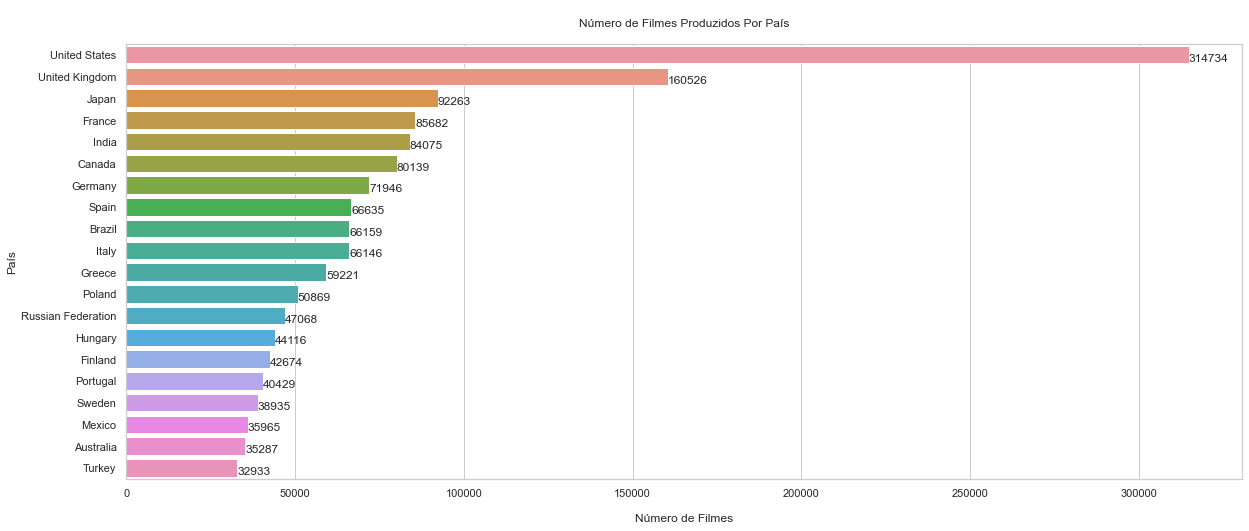

In [98]:
# Plot

# Figura
plt.figure(figsize = (20,8))

# Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

# Loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

## 9- Quais São os Top 10 Melhores Filmes?

Top 10 filmes com melhor avaliação e mais de 25 mil votos.

In [99]:
# Consulta SQL
consulta9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10          
            ''' 

In [100]:
# Resultado
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)

In [101]:
display(top10_melhores_filmes)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
4,12 Angry Men,"Crime,Drama",9.0
5,The Godfather Part II,"Crime,Drama",9.0
6,Schindler's List,"Biography,Drama,History",9.0
7,The Lord of the Rings: The Return of the King,"Action,Adventure,Drama",9.0
8,The Dark Knight,"Action,Crime,Drama",9.0
9,Mirror Game,"Crime,Mystery,Thriller",9.0


## 10- Quais São os Top 10 Piores Filmes?

Top 10 filmes com pior avaliação e mais de 25 mil votos.

In [102]:
# Consulta SQL
consulta10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
            ''' 

In [103]:
# Resultado
top10_piores_filmes = pd.read_sql_query(consulta10, conn)

In [104]:
display(top10_piores_filmes)

,Movie_Name,genres,rating
0,Reis,"Biography,Drama",1.0
1,Cumali Ceber,Comedy,1.0
2,Sadak 2,"Action,Drama",1.1
3,Smolensk,"Drama,Thriller",1.2
4,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.5
5,The Cost of Deception,"Crime,Drama,History",1.5
6,Manos: The Hands of Fate,Horror,1.6
7,Justin Bieber: Never Say Never,"Documentary,Music",1.6
8,From Justin to Kelly,"Comedy,Musical,Romance",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9
